In [2]:
import os, sys
import pandas as pd 
import numpy as np
from tqdm import tqdm
tqdm.pandas() # for progress_apply

process_dir = os.getcwd() # get the current directory before changing it
if os.getcwd().split("/")[-1] != "lobbying-market":
    sys.path.append("../..") # add main repo directory to path
    os.chdir("../..") # change to main repo directory

from crpapi import CRP
from utils.API_keys import get_opensecrets_key

## Strategy: As with the SEC data, we will scrape the opensecrets to collect lobbying data for our list of companies. 
**Objective:** Scrap data from tables like these for each company:

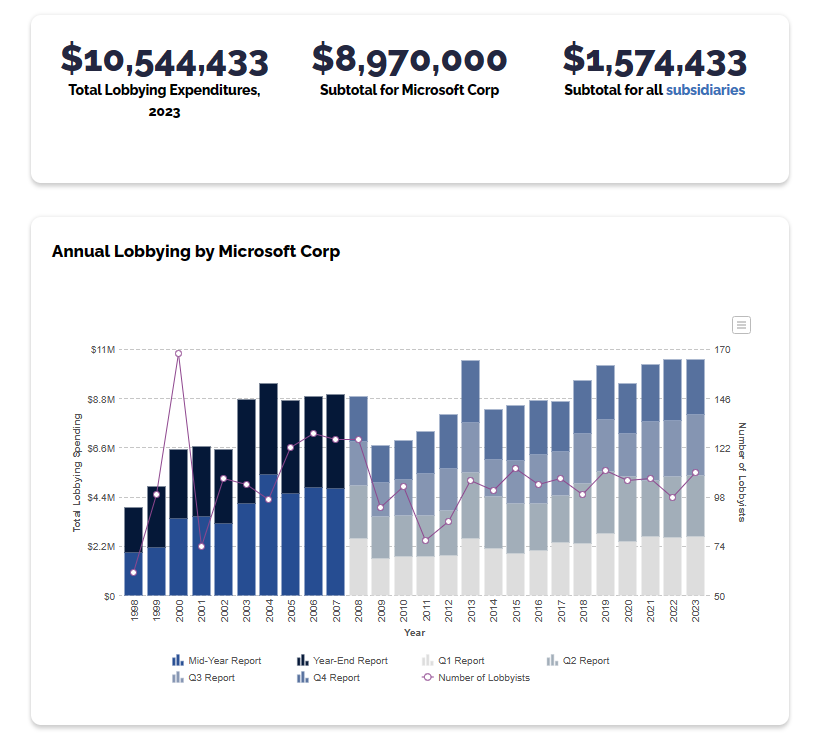

Src: https://www.opensecrets.org/federal-lobbying/clients/summary?cycle=2023&id=D000000115

**How to Do This:** See the `junk/opensecrets_pipeline.ipynb` files for more details. But, the key is to use the *opensecrets* API to extract the `orgid` corresponding to each company. This is convenient because it accepts many variants of the same name. The art is to test different names correctly. Then, we can add the `orgid` to a standard link (see the Src link above) to load the webpage and scrape the data.

### 1. Updating Assets dataframe with CRP orgids for ~100 Stocks (~7 min)
There is some manual name-editing going on here (see `get_os_details` function below and the output of the function in `junk/opensecrets_companyIDs copy.ipynb`)

In [7]:
# loading processed company data dataframe affected by typo (fix in cell below)
df = pd.read_pickle('data_processing/sec_assets_scrape/assets.pkl') #to load 123.pkl back to the dataframe df

idx = np.arange(137) # extra row that will be removed (ROSS - ID 59)
mask = np.ones(len(idx), dtype=bool)
mask[[48, 51, 90, 102]] = False # remove these rows (there is no orgid associated with them)
idx = idx[mask].copy()

df_sub = df.iloc[idx]
df_sub.reset_index(inplace=True)
names = df['title'].values

In [8]:
crp=CRP(get_opensecrets_key()) #makes a CRP object

object_methods = [method_name for method_name in dir(crp) if callable(getattr(crp, method_name))]
print(dir(crp))

['BASE_URI', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'apikey', 'candidates', 'committees', 'fetch', 'http', 'indexp', 'orgs']


In [9]:
def get_os_details(name):
    def format_name(name):
        # standard name formatter
        name = name.lower()
        name = name.replace(',', '')
        if ' com ' in name:
            name = name.replace(' com ', '.com ')
            name = name.replace('inc.', '')
            name = name.replace('inc', '')
        if 'inc.' in name:
            name = name.replace('inc.', 'inc')
        return name

    try:
        # manual fixes
        if name == 'Monster Beverage Corp':
            orgs = crp.orgs.get('Monster Energy')
            return orgs['@attributes']['orgid']
        if name == 'TAKE TWO INTERACTIVE SOFTWARE INC':
            orgs = crp.orgs.get('Take-Two Interactive Software')
            return orgs['@attributes']['orgid']
        if name == 'Warner Bros. Discovery, Inc.':
            orgs = crp.orgs.get('Warner Brothers Discovery')
            return orgs['@attributes']['orgid']
        if name == 'HUNT J B TRANSPORT SERVICES INC':
            orgs = crp.orgs.get('JB Hunt Transport Services')
            return orgs['@attributes']['orgid']
        if name == 'TPG Inc.':
            orgs = crp.orgs.get('TPG Capital')
            return orgs['@attributes']['orgid']
        if name == 'Warner Music Group Corp.':
            orgs = crp.orgs.get('Warner Music Group')
            return orgs['@attributes']['orgid']

        # different variants of name
        # check the first word of the name, then the first two words, etc.
        # if the name is not uniquely identified (dtype = list) or not found, return np.nan
        if ' ' in name:
            name_list = name.split(' ')
            for n in range(len(name_list)):
                if n == 0:
                    name = format_name(name_list[0])
                    try:
                        orgs = crp.orgs.get(name)
                    except:
                        continue
                else:
                    # print(name_list[:(n+1)])
                    # orgs = crp.orgs.get(name_list[:(n+1)].join(' '))
                    name = ' '.join(name_list[:(n+1)])
                    name = format_name(name)
                    # print(name)
                    orgs = crp.orgs.get(name)
                    
                if type(orgs) == dict:
                    return orgs['@attributes']['orgid']
                else:
                    for n in range(len(orgs)):
                        org = orgs[n]
                        if org['@attributes']['orgname'].lower() == name:
                            return org['@attributes']['orgid']

        else:
            orgs = crp.orgs.get(name)
            return orgs['@attributes']['orgid']

    except:
        return np.nan

df_sub['os_orgid'] = df_sub['title'].progress_apply(get_os_details)

  0%|          | 0/133 [00:00<?, ?it/s]

100%|██████████| 133/133 [07:55<00:00,  3.58s/it]
/tmp/ipykernel_12905/3838601489.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['os_orgid'] = df_sub['title'].progress_apply(get_os_details)


In [10]:
# check
df_sub[['ticker','os_orgid']]

,ticker,os_orgid
0,MSFT,D000000115
1,AAPL,D000021754
2,NVDA,D000036303
3,GOOGL,D000067823
4,AMZN,D000023883
...,...,...
128,SWKS,D000091433
129,TER,D000074301
130,WMG,NaN
131,CG,D000000810


### 2. Extracting the OpenSecrets Tabular data (quarterly only) via Webscrape

In [11]:
## Import what you'll need here
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import os
import ast
from time import sleep
import json
import numpy as np

os.environ['MOZ_HEADLESS'] = '1' # prevents browser from popping up
dr = webdriver.Firefox() # open a FireFox browser

In [12]:
def get_lobbying_data(orgid):
    # using beautiful soup to obtain the html content of the page
    dr.get("https://www.opensecrets.org/federal-lobbying/clients/summary?id=" + str(orgid))
    soup = BeautifulSoup(dr.page_source,
    'html.parser')
    result = soup.find_all('div')

    # the data is stored in the 37th div tag
    try:
        data = result[36].find_all('div', attrs = {'class' : "FusionChart"})[0]['data-source']
    except:
        return None
    data = json.loads(data) # behaves better than ast.literal_eval (since the file is json)

    # extract the data from the json file
    years = data['categories'][0]['category']
    q_dict = {}
    q_dict['q1'] = data['dataset'][0]['dataset'][2]['data']
    q_dict['q2'] = data['dataset'][0]['dataset'][3]['data']
    q_dict['q3'] = data['dataset'][0]['dataset'][4]['data']
    q_dict['q4'] = data['dataset'][0]['dataset'][5]['data']
    num_lobbyists = data['lineset'][0]['data']
    
    # make an array that shows lobbying costs per quarter
    lobbying_costs = np.zeros((4, len(years)))
    for i, q in enumerate(['q1', 'q2', 'q3', 'q4']):
        for j, year in enumerate(years):
            try:
                lobbying_costs[i, j] = q_dict[q][j]['value']
            except:
                lobbying_costs[i, j] = -1

    # make a dataframe that shows lobbying costs per quarter and year
    df = pd.DataFrame()
    df['year'] = np.repeat([int(year['label']) for year in years], 4)
    df['quarter'] = ['Q1', 'Q2', 'Q3', 'Q4'] * len(years)
    df['lobbying_costs'] = lobbying_costs.flatten('F')

    # remove rows with -1 values
    df = df[df['lobbying_costs'] != -1]

    return df

df_sub['lobbying_summary'] = df_sub['os_orgid'].progress_apply(get_lobbying_data)

100%|██████████| 133/133 [02:11<00:00,  1.01it/s]
/tmp/ipykernel_12905/4134147738.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['lobbying_summary'] = df_sub['os_orgid'].progress_apply(get_lobbying_data)


In [14]:
df_sub.to_pickle(process_dir + '/' + 'unprocessed_lobbying_assets.pkl') #to save the dataframe df to 123.pkl

### 3. Light Cleaning

In [16]:
# filter out data with nans for os_orgid and None for lobbying_summary and 0-length dataframe for lobbying_summary
df_sub_f = df_sub.dropna(axis=0, how='any').copy()
df_sub_f = df_sub_f[df_sub_f['lobbying_summary'].apply(lambda x: x is not None and len(x) > 0)]

# reset indices
df_sub_f.reset_index(inplace=True)

### 4. Merge Assets and Lobbying Data by Quarter and Date

In [19]:
def merge_assets_lobbying(df):
    assets = df['assets_summary']
    assets['year'] = assets['year'].astype(int) # convert year to int for merging
    
    lobbying = df['lobbying_summary']

    # merge assets and lobbying dataframes
    merged_df = pd.merge(assets, lobbying, on = ['year', 'quarter'], how = 'inner')

    return merged_df

df_sub_f['merged_summary'] = df_sub_f.progress_apply(merge_assets_lobbying, axis = 1)

  0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 111/111 [00:00<00:00, 433.69it/s]


In [20]:
df_sub.to_pickle(process_dir + '/' + 'lobbying_assets.pkl') #to save the dataframe df to 123.pkl

(10000000.0, 1000000000000.0)

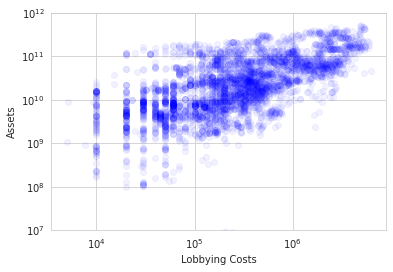

In [22]:
import matplotlib.pyplot as plt
for i in range(len(df_sub_f)):
    combined_df = df_sub_f.loc[i].merged_summary
    plt.loglog(combined_df['lobbying_costs'], combined_df['val'], 'o', c = 'b', alpha = 0.05)
plt.xlabel('Lobbying Costs')
plt.ylabel('Assets')
plt.ylim(1e7, 1e12)